In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [45]:
## Cargar el dataset desde el repositorio de GITHUB
url = 'https://raw.githubusercontent.com/ITACADEMYprojectes/projecteML/main/Ecommerce_Customers.csv'
df = pd.read_csv(url)
df.head() # cargado correctamente

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [ ]:
## Sobre el DataSet
# Avatar: Esta columna representa un Color de Avatar elegido por el cliente.
# AvgSessionLength: la duración media de las sesiones (Minutos) de Móvil y Sitio Web.
# Time on App: la cantidad total de tiempo (Minutos) que un cliente pasa usando la aplicación móvil.
# Time on Website: la cantidad total de tiempo (minutos) que un cliente pasa en el sitio web.
# Length of Membership: la duración de la membresía de cada cliente (Meses)
# Yearly Amount Spent:la cantidad total de dinero gastado por cada cliente en los productos de la empresa a lo largo de un año


In [47]:
## EDA

df.info() # no hay valores nulos. ¡Hay 3 variables object! Hay variables con información sensible (Email y Address son Información de identificación personal (IIP))
df.describe() # Las escalas de las variables numéricas son diferentes. Los clientes pasan más tiempo en la web que en la app

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


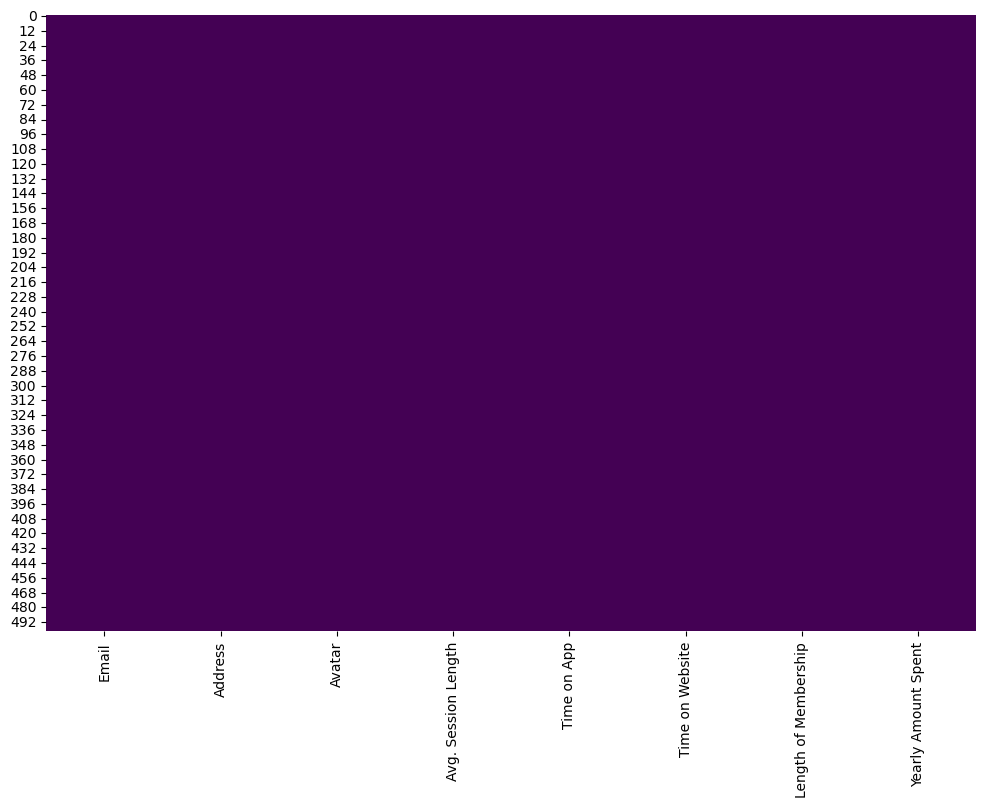

Email                   0
Address                 0
Avatar                  0
Avg. Session Length     0
Time on App             0
Time on Website         0
Length of Membership    0
Yearly Amount Spent     0
dtype: int64

In [49]:
## VALORES NULOS
# Visualización de valores nulos
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show() #confirmamos que no hay valores nulos
df.isnull().sum()


In [51]:
## TRATAMIENTO DE INFORMACIÓN SENSIBLE
# Anonimització i Pseudonimització: S'aplicaran hash per a l'email i la substitució per codis per a Address. Si bien la variable Address podría utilizarse como predictora del gasto anual, en este ejercicio no la utilizaremos.
# Función para hashear el email
def hash_email(Email):
    Email = Email.lower()
    sha256 = hashlib.sha256()
    sha256.update(Email.encode('utf-8'))
    return sha256.hexdigest()

In [53]:
# Aplicar la función de hashing a la columna de correos electrónicos
df['Email'] = df['Email'].apply(hash_email)

In [59]:
# Ver las primeras 5 filas de la columna Email para verificar
df['Email'].head()

0    aa28bba74bc4dd616ef1d8b7117388c1867dce335ba2d5...
1    8b7f5ea06b55eb72f011c377ab02195b975d8111431c81...
2    f653f93248d05ca5a9dfbfe52d687a4371612389ad82ff...
3    e03e10d58a70c753195528710bc0c714daf503feb39302...
4    168a350075ccaa89092da8c336d6f7ed6a41c6a036dc01...
Name: Email, dtype: object

In [61]:
# Crear una función para pseudoanonymizar las direcciones
def pseudoanonymize_addresses(df, Address):
    # Crear un diccionario que asigna códigos únicos a cada dirección
    unique_addresses = df[Address].unique()
    address_to_code = {address: f'ADDR{index+1}' for index, address in enumerate(unique_addresses)}
    
    # Reemplazar las direcciones en el DataFrame por sus códigos correspondientes
    df[Address] = df[Address].map(address_to_code)
    
    return df, address_to_code

In [63]:
# Aplicar la función
df, address_to_code = pseudoanonymize_addresses(df, 'Address')

In [65]:
# Ver las primeras 5 filas de Address
df['Address'].head()

0    ADDR1
1    ADDR2
2    ADDR3
3    ADDR4
4    ADDR5
Name: Address, dtype: object

In [67]:
## DIVISIÓN DEL DATASET
# para modelos de clasificación, antes de dividir el conjunto, hay que analizar el balance entre las clases
# Dividir el dataset en conjuntos de entrenamiento y prueba
train, test = train_test_split(df, test_size=0.2, random_state=22)
print("Tamaño del conjunto de entrenamiento (train):", train.shape)
print("Tamaño del conjunto de prueba (test):", test.shape)

Tamaño del conjunto de entrenamiento (train): (400, 8)
Tamaño del conjunto de prueba (test): (100, 8)


In [69]:
# Guardar los conjuntos en archivos CSV
train.to_csv('ecommerce_train.csv', index=False)
test.to_csv('ecommerce_test.csv', index=False)

In [73]:
# Chequear las primeras filas de ambos conjuntos
train.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
94,d3cad99dcb7c750e070c25b63cb7ac60b938544195456d...,ADDR95,DarkGoldenRod,32.197724,11.830231,36.633857,4.193325,514.088958
350,01805861c6e41de1c24f6575cf76b16cf3c359508ab145...,ADDR351,SaddleBrown,33.304337,12.692661,37.333591,3.827376,535.480775
288,d81f81656a74822b3c00094160a77884d700dff6301424...,ADDR289,AntiqueWhite,32.312910,9.824402,35.742779,2.921350,356.615568
420,e515eed045f62012901a5e1c3c424eacb025506c78170e...,ADDR421,HotPink,33.215472,12.135101,37.142094,5.840506,663.803693
163,40925de10d335b271864ce3f6229846d98a226ad94737a...,ADDR164,LimeGreen,30.879484,13.280432,36.936159,3.585161,490.206600


In [75]:
test.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
453,2c01467b0ea3f6f1e3806ba12e060a1702aafcd87aa7e1...,ADDR454,Lime,33.676831,10.971392,37.722367,3.629340,478.183060
286,85c992b6b0495b375938f7637d3f46b9d863e5753fbeb4...,ADDR287,RoyalBlue,33.708153,14.325655,35.721827,3.634340,626.018673
262,b7e0ff0740edeac44c760402bb38be09edc634bdc92ce1...,ADDR263,Crimson,32.582494,11.739744,36.854811,2.182017,376.496841
296,d46eeaceb6f687dd21804c94d0a5dbc3ceaddd83449225...,ADDR297,Cyan,33.612563,11.470565,37.061689,3.802511,506.423860
152,a52fc9b0d2f6f743f9d5bce54529899eeb219d5cb76af0...,ADDR153,CornflowerBlue,32.510218,10.984836,37.396497,5.391275,555.892595


In [77]:
## DETECCIÓN DE OUTLIERS
# Crear el diagrama de caja
# Leer el conjunto de entrenamiento desde el archivo CSV
train = pd.read_csv('ecommerce_train.csv')

In [79]:
# Listar columnas para detectar outliers
columns_to_check = ['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']

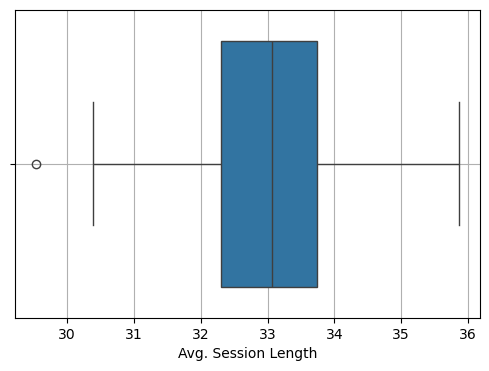

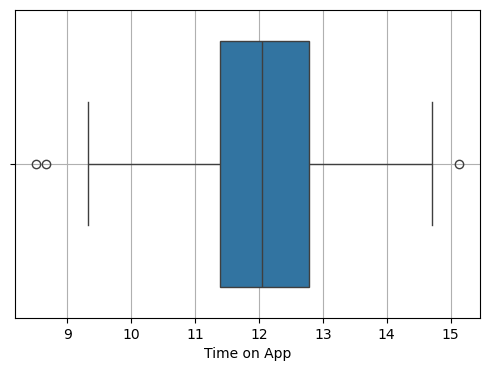

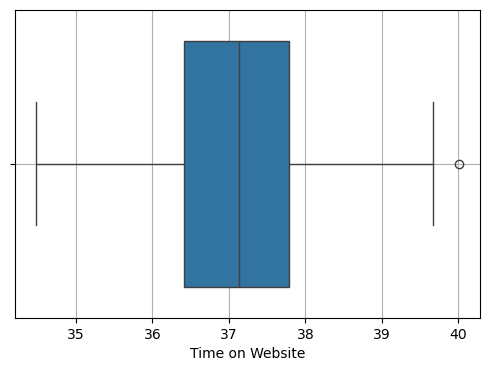

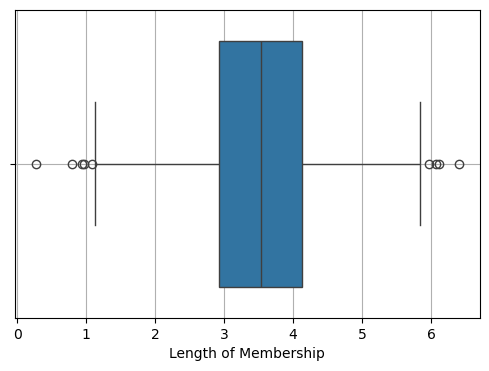

In [81]:
# Crear diagramas de caja para visualizar outliers en cada columna
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # Se detectaron outliers en todas las columnas señaladas. La que tiene más es Length of Membership

In [83]:
# Para tratar los outliers se aplicará la técnica de Winsorización para mantener la estructura del dataset
# Función para calcular límites IQR
def calculate_iqr_limits(df, columns):
    limits_dict = {}
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        limits_dict[column] = (lower_bound, upper_bound)
        
    return limits_dict

In [85]:
# Función para winsorizar datos
def winsorize_data(df, columns):
    limits_dict = calculate_iqr_limits(df, columns)
    
    for column, (lower_bound, upper_bound) in limits_dict.items():
        # Winsorizar: Reemplazar valores menores que el límite inferior y mayores que el límite superior
        df[column] = np.clip(df[column], lower_bound, upper_bound)
        
    return df

In [87]:
# Leer el conjunto de entrenamiento desde el archivo CSV
train = pd.read_csv('ecommerce_train.csv')

In [89]:
# Definir las columnas a winsorizar
columns_to_check = ['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']

In [91]:
# Aplicar winsorización a las columnas especificadas
train_winsorized = winsorize_data(train, columns_to_check)

In [93]:
# Guardar el DataFrame en un archivo CSV
train_winsorized.to_csv('ecommerce_train.csv', index=False)

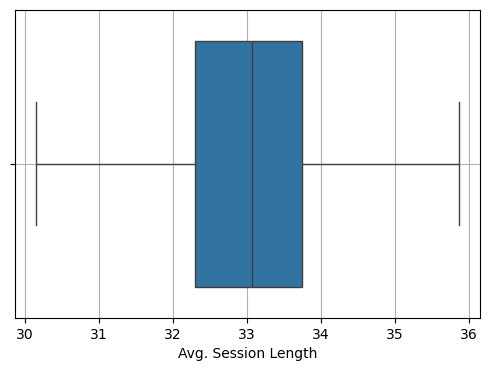

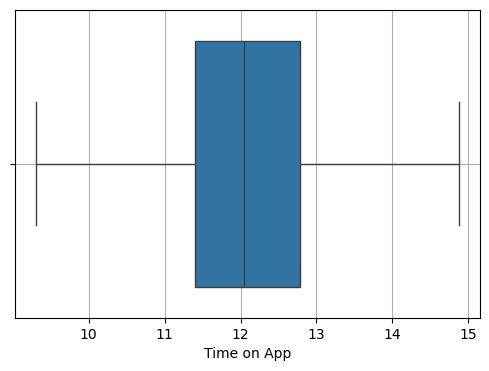

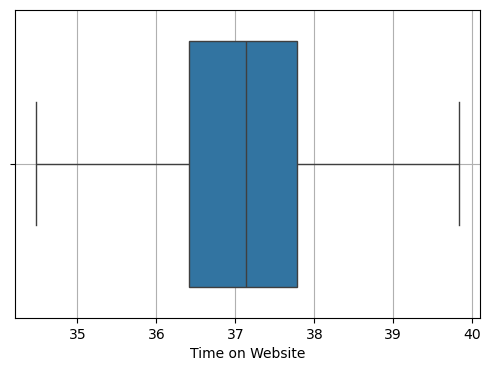

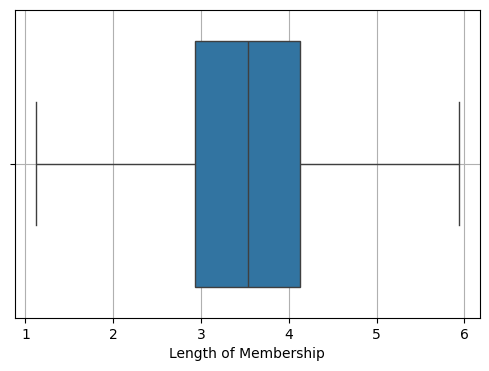

In [95]:
# Comprobamos que no haya outliers
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # No se detectan outliers

In [ ]:
# Mostrar las primeras 5 filas del DataFrame `train`
train.head()

In [ ]:
# Obtener una descripción estadística del DataFrame `train`
train.describe()

In [101]:
## SELECCIÓN DE CARACTERÍSTICAS RELEVANTES APLICANDO MÉTODO DE FILTRO
# Leer el conjunto de entrenamiento desde el archivo CSV
train = pd.read_csv('ecommerce_train.csv')

In [103]:
# Filtrar solo las columnas numéricas
train_numeric = train.select_dtypes(include=['number'])

In [105]:
# Correlación de características
corr_matrix = train_numeric.corr()

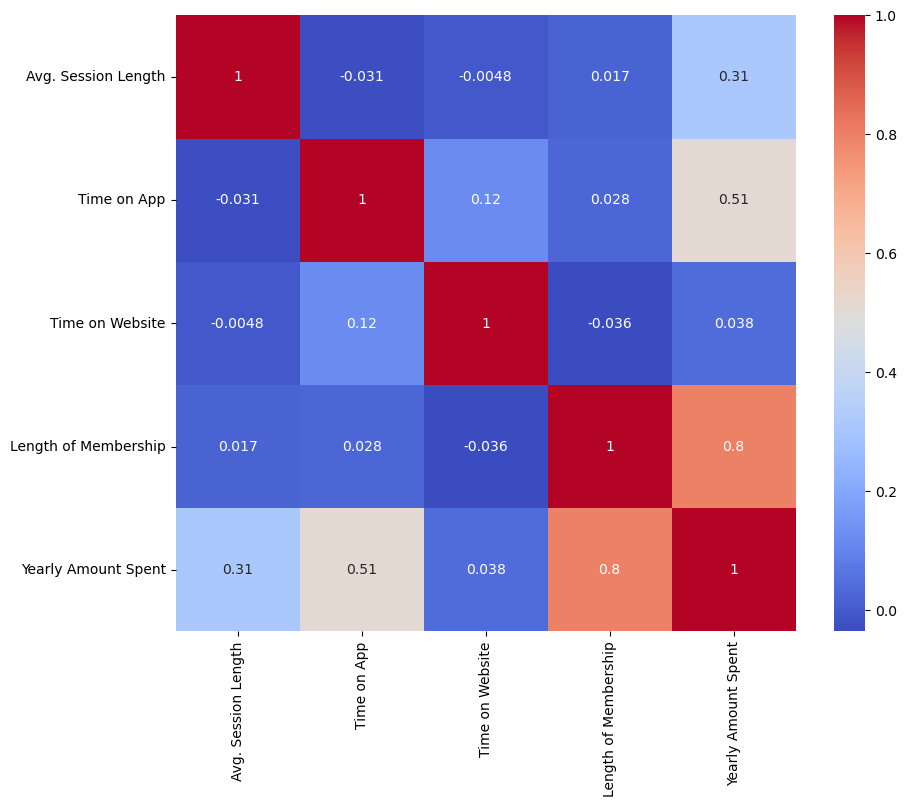

In [107]:
# Mostrar la correlación entre características y la variable objetivo
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Hay una correlación lineal positiva fuerte entre Lenght of Membership y Yearly Amount Spent
# Hay una correlación lineal positiva moderada entre Time on App y Yearly Amount Spent
# Hay una correlación lineal positiva debil entre Avg. Session Lenght y Yearly Amount Spent
# No hay correlación entre Time on Website y Yearly Amount Spent
# Las características seleccionadas serán: Lenght of Membership, Time on App y Avg. Session Lenght

In [109]:
## ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS
# Leer el DataFrame
train = pd.read_csv('ecommerce_train.csv')

In [111]:
# Especificar las columnas numéricas a estandarizar
columns_to_standardize = ['Length of Membership', 'Time on App', 'Avg. Session Length']

In [113]:
# Inicializar el escalador
scaler = StandardScaler()

In [115]:
# Aplicar la estandarización solo a las columnas numéricas
train[columns_to_standardize] = scaler.fit_transform(train[columns_to_standardize])

In [117]:
# Guardar el DataFrame estandarizado en el mismo archivo CSV
train.to_csv('ecommerce_train.csv', index=False)

In [119]:
# Verificar estandarización. Recordar que no se estandariza la variable objetivo porque queremos mantener la interpretación en su escala original.
train.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000
mean,-2.131628e-16,1.576517e-16,37.124609,3.641532e-16,500.383411
std,1.001252e+00,1.001252e+00,1.007107,1.001252e+00,78.634586
min,-2.952393e+00,-2.778902e+00,34.476878,-2.486463e+00,256.670582
25%,-7.534726e-01,-6.927340e-01,36.415425,-6.341668e-01,448.312776
50%,2.864480e-02,-4.764733e-02,37.137610,-9.890671e-03,498.476041
75%,7.124744e-01,6.980449e-01,37.780484,6.006973e-01,549.871479
max,2.881983e+00,2.784213e+00,39.828072,2.452993e+00,765.518462


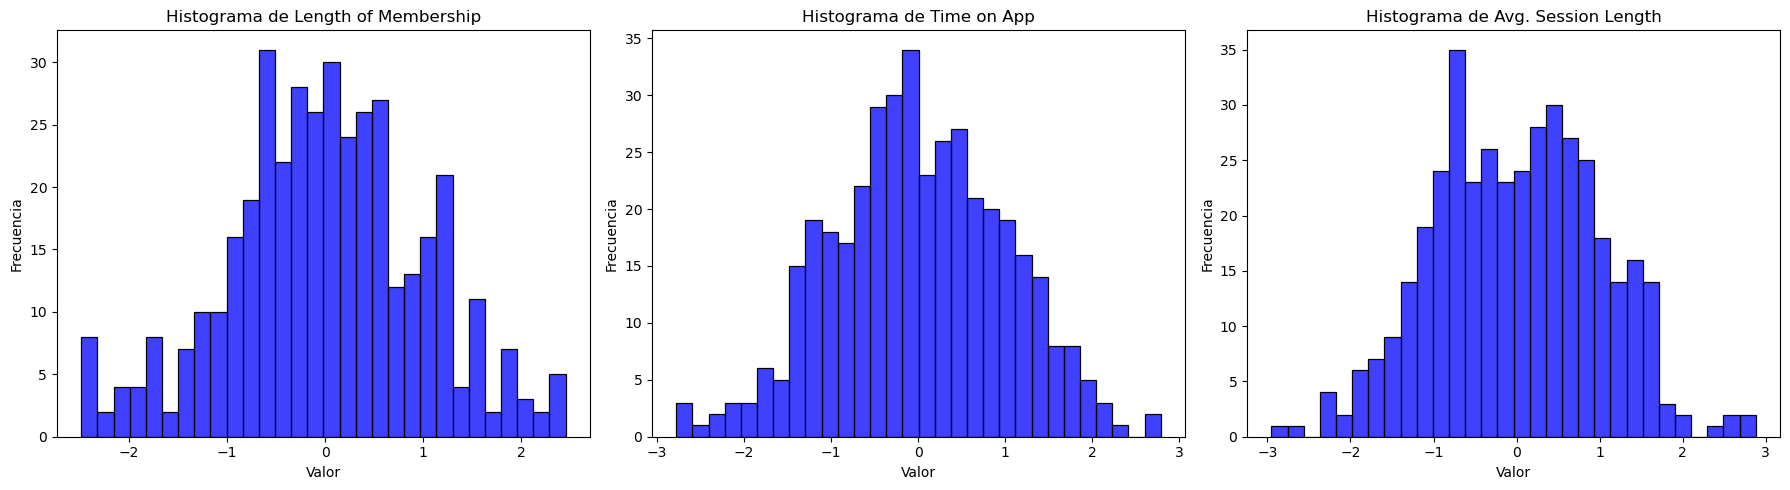

In [121]:
#Chequear el resultado con histogramas para ver media 0 y desvío estándar=1
# Crear una figura con subgráficos para cada columna numérica
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
# Definir las columnas para visualizar
columns_to_plot = ['Length of Membership', 'Time on App', 'Avg. Session Length']
# Iterar sobre cada columna para crear un histograma
for i, column in enumerate(columns_to_plot):
    sns.histplot(train[column], kde=False, ax=axes[i], color='blue', bins=30)
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frecuencia')
# Ajustar el diseño
plt.tight_layout()
plt.show()

In [123]:
## APLICAR TODAS LAS TRANSFORMACIONES AL CONJUNTO DE PRUEBA (PASO A PASO SI SON POCAS O CON UN PIPELINE SI SON VARIAS)
# Leer el conjunto de prueba desde el archivo CSV
test = pd.read_csv('ecommerce_test.csv')

In [125]:
test.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,2c01467b0ea3f6f1e3806ba12e060a1702aafcd87aa7e1...,ADDR454,Lime,33.676831,10.971392,37.722367,3.629340,478.183060
1,85c992b6b0495b375938f7637d3f46b9d863e5753fbeb4...,ADDR287,RoyalBlue,33.708153,14.325655,35.721827,3.634340,626.018673
2,b7e0ff0740edeac44c760402bb38be09edc634bdc92ce1...,ADDR263,Crimson,32.582494,11.739744,36.854811,2.182017,376.496841
3,d46eeaceb6f687dd21804c94d0a5dbc3ceaddd83449225...,ADDR297,Cyan,33.612563,11.470565,37.061689,3.802511,506.423860
4,a52fc9b0d2f6f743f9d5bce54529899eeb219d5cb76af0...,ADDR153,CornflowerBlue,32.510218,10.984836,37.396497,5.391275,555.892595


In [129]:
# Aplicar winsorización
# Aplicar winsorización a las columnas especificadas
test_winsorized = winsorize_data(test, columns_to_check)

# Guardar el DataFrame en un archivo CSV
test_winsorized.to_csv('ecommerce_test.csv', index=False)

In [131]:
# Estandarizar

test = pd.read_csv('ecommerce_test.csv')
# Aplicar la estandarización solo a las columnas numéricas
columns_to_standardize = ['Length of Membership', 'Time on App', 'Avg. Session Length']
test[columns_to_standardize] = scaler.transform(test[columns_to_standardize])

# Guardar el DataFrame estandarizado en el mismo archivo CSV
test.to_csv('ecommerce_test.csv', index=False)

# Verificar estandarización. Recordar que no se estandariza la variable objetivo
test.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,2c01467b0ea3f6f1e3806ba12e060a1702aafcd87aa7e1...,ADDR454,Lime,0.651211,-1.114582,37.722367,0.086416,478.183060
1,85c992b6b0495b375938f7637d3f46b9d863e5753fbeb4...,ADDR287,RoyalBlue,0.683213,2.237080,35.721827,0.091545,626.018673
2,b7e0ff0740edeac44c760402bb38be09edc634bdc92ce1...,ADDR263,Crimson,-0.466867,-0.346827,36.854811,-1.398086,376.496841
3,d46eeaceb6f687dd21804c94d0a5dbc3ceaddd83449225...,ADDR297,Cyan,0.585549,-0.615797,37.061689,0.264036,506.423860
4,a52fc9b0d2f6f743f9d5bce54529899eeb219d5cb76af0...,ADDR153,CornflowerBlue,-0.540710,-1.101149,37.396497,1.893612,555.892595


In [133]:
## ENTRENAR EL MODELO
# Validación cruzada para hacer varias pruebas
train = pd.read_csv('ecommerce_train.csv')
test = pd.read_csv('ecommerce_test.csv')

In [135]:
# Especificar las columnas para características y variable objetivo
feature_columns = ['Length of Membership', 'Time on App', 'Avg. Session Length']
target_column = 'Yearly Amount Spent'

# Separar características (X) y variable objetivo (y) en el conjunto de entrenamiento
X_train = train[feature_columns]
y_train = train[target_column]

# Separar características (X) y variable objetivo (y) en el conjunto de prueba
X_test = test[feature_columns]
y_test = test[target_column]

# Crear el modelo de regresión lineal
model = LinearRegression()

# Configurar el K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Crear scorers para el Mean Squared Error y el R^2 Score
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Evaluar el modelo utilizando cross_val_score con el MSE como métrica
mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mse_scorer)
# Evaluar el modelo utilizando cross_val_score con el R^2 como métrica
r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=r2_scorer)

# Imprimir los resultados
print(f"Mean Squared Error de cada fold: {-mse_scores}")  # Convertir a positivo
print(f"Mean Squared Error Promedio: {-mse_scores.mean()}")
print(f"Desviación Estándar del Mean Squared Error: {mse_scores.std()}")

print(f"R^2 Score de cada fold: {r2_scores}")
print(f"R^2 Score Promedio: {r2_scores.mean()}")
# Las métricas sugieren que el modelo funciona bien. Vamos a ajustarlo con el conjunto de entrenamiento completo.



Mean Squared Error de cada fold: [128.34184734 107.81331083 137.76549166 104.9684111   91.22004935
  75.54488238 149.59959389 130.09546651  91.73855933 103.76799273]
Mean Squared Error Promedio: 112.08556051115337
Desviación Estándar del Mean Squared Error: 22.31157587124232
R^2 Score de cada fold: [0.98258848 0.98142899 0.98022074 0.97354293 0.98058309 0.99043041
 0.97976951 0.97887639 0.98415463 0.97920979]
R^2 Score Promedio: 0.9810804961994528


In [137]:
# Entrenar el modelo con los datos de entrenamiento completo
model.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Mostrar los coeficientes del modelo
print("Coeficientes:", model.coef_)
print("Intercepto:", model.intercept_) # lAS MÉTRICAS DE EVALUACIÓN INDICAN QUE EL MODELO FUNCIONA BIEN.


Mean Squared Error: 162.52151591357256
R^2 Score: 0.9757308676711577
Coeficientes: [61.42851386 39.28370583 24.77130455]
Intercepto: 500.3834111992853


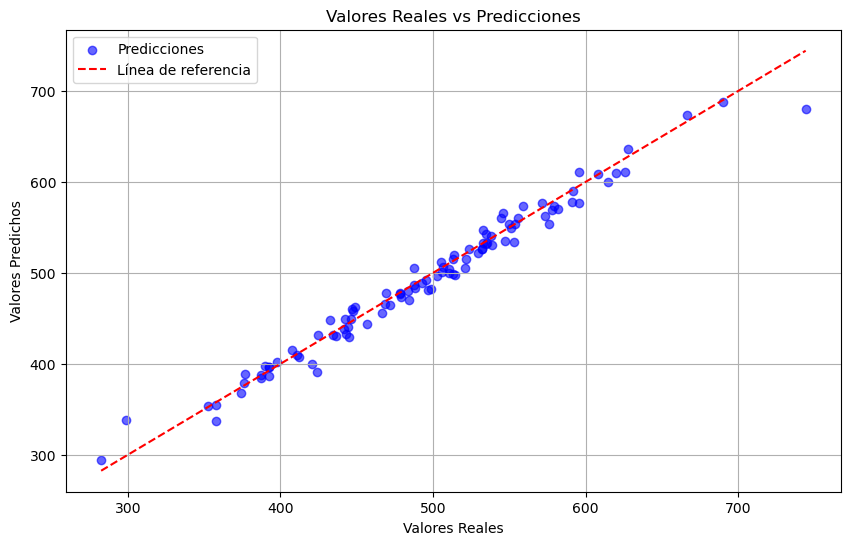

In [139]:
# Gráfico de valores predichos y valores reales
# Crear una figura
plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicciones', color='blue')

# Añadir una línea de referencia (línea de 45 grados)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Línea de referencia')

# Añadir etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show() # Las predicciones se ajustan a los valores reales.

In [ ]:
## GUARDAR EL MODELO Y EL ESCALADOR

In [141]:

# Guardar el modelo
with open('linear_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Guardar el escalador
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)